<div align="center" col="blue">

<h1>
<font color="blue">Praktikum Social Media Mining</font>
</h1>

<h3> Fradinka Amelia Edyputri - 16442045</h3>

</div>


In [55]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,  calinski_harabasz_score, davies_bouldin_score
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter
import community

# **Scrape Tweet Menggunaka tweet-harvest Mengenai Topik Gempa Megathrust**

In [34]:
#@title Twitter Auth Token

twitter_auth_token = '****************************************'

In [ ]:
#Import required Python package
!pip install pandas

# Install Node.js (because tweet-harvest built using Node.js)
!sudo apt-get update
!sudo apt-get install -y ca-certificates curl gnupg
!sudo mkdir -p /etc/apt/keyrings
!curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg

!NODE_MAJOR=20 && echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_$NODE_MAJOR.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list

!sudo apt-get update
!sudo apt-get install nodejs -y

!node -v

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,318 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:14 https://r2u.stat.ill

In [ ]:
# Crawl Data

filename = 'tweet_megathrust.csv'
search_keyword = 'megathrust since:2024-01-01 until:2024-09-27 lang:id'
limit = 300

!npx -y tweet-harvest@2.6.1 -o "{filename}" -s "{search_keyword}" --tab "LATEST" -l {limit} --token {twitter_auth_token}

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹Tweet Harvest [v2.6.1]

Research by Helmi Satria
Use it for Educational Purposes only!

This script uses Chromium Browser to crawl data from Twitter with your Twitter auth token.
Please enter your Twitter auth token when prompted.

Note: Keep your access token secret! Don't share it with anyone else.
Note: This script only runs on your local device.


Opening twitter search page...


-- Scrolling... (1)
Filling in keywords: megathrust since:2024-01-01 until:2024-09-27 lang:id

 (2)

Your tweets saved to: /content/tweets-data/tweet_megathrust.csv
Total tweets saved: 16

-- Scrolling... (1) (2)

Your tweets saved to: /content/tweets-data/tweet_megathrust.csv
Total tweets saved: 21


Your tweets saved to: /content/tweets-data/tweet_megathrust.csv
Total tweets saved: 38

-- Scrolling... (1)

Your tweets saved to: /content/tweets-data/tweet_megathrust.csv
Total tweets saved: 52

-- Scrolling... (1)

Your tweets saved to: /content/tweets-data/tweet_megathrust.csv
Total tweets sav

In [ ]:
df_tweets = pd.read_csv("tweets-data/tweet_megathrust.csv", delimiter=",")
df_tweets.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1839334909535723662,Thu Sep 26 16:03:10 +0000 2024,2,Pelatihan Penanggulangan Bencana Bertema Megat...,1839334909535723662,https://pbs.twimg.com/media/GYahGdhbMAE8o8V.jpg,NaN,in,"Kebumen, Indonesia",0,0,0,https://x.com/Pusdalops_Kbm/status/18393349095...,945893297695760384,Pusdalops_Kbm
1,1839318092423602301,Thu Sep 26 14:56:20 +0000 2024,1,Dalam rangka menyongsong Bulan Pengurangan Ris...,1839318092423602301,https://pbs.twimg.com/ext_tw_video_thumb/18393...,NaN,in,NaN,0,0,0,https://x.com/BintangSoesman/status/1839318092...,1453637635562299392,BintangSoesman
2,1839142276880281925,Thu Sep 26 12:29:33 +0000 2024,1,@_TheHolocaust Ahaha karna dikit2 bawa2 agama ...,1839281153003630636,NaN,_TheHolocaust,in,Indonesia,0,1,0,https://x.com/LAlverno/status/1839281153003630636,2580363818,LAlverno
3,1839258222223569152,Thu Sep 26 11:17:24 +0000 2024,0,@zhoreia IMUYNYA JIMAT PROTEKSI RUMAH DARI GEM...,1839262996943745359,NaN,zhoreia,in,NaN,0,1,0,https://x.com/httpsxixi/status/183926299694374...,739796014500962304,httpsxixi
4,1838856480579285290,Thu Sep 26 10:00:08 +0000 2024,0,@WowokGg @youadams_ @folkshittmedia Emang kalo...,1839243548564271126,NaN,WowokGg,in,NaN,0,0,0,https://x.com/Pelangi28342329/status/183924354...,1131222461591236609,Pelangi28342329


In [ ]:
num_tweets = len(df_tweets)
print(f"Jumlah data tweet dalam dataframe adalah: {num_tweets}.")

Jumlah data tweet dalam dataframe adalah: 317.


# **Preprocessing**

In [ ]:
data_tweet = df_tweets[['full_text']]
data_tweet.head()

,full_text
0,Pelatihan Penanggulangan Bencana Bertema Megat...
1,Dalam rangka menyongsong Bulan Pengurangan Ris...
2,@_TheHolocaust Ahaha karna dikit2 bawa2 agama ...
3,@zhoreia IMUYNYA JIMAT PROTEKSI RUMAH DARI GEM...
4,@WowokGg @youadams_ @folkshittmedia Emang kalo...


## **Casefolding Lowecase**

> Melakukan casefolding berupa lowercase untuk menyeragam bentuk data teks menjadi huruf kecil semua.

In [ ]:
data_tweet['lowercase'] = data_tweet['full_text'].str.lower()
data_tweet.head()

<ipython-input-23-bd43fee5033f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['lowercase'] = data_tweet['full_text'].str.lower()


,full_text,lowercase
0,Pelatihan Penanggulangan Bencana Bertema Megat...,pelatihan penanggulangan bencana bertema megat...
1,Dalam rangka menyongsong Bulan Pengurangan Ris...,dalam rangka menyongsong bulan pengurangan ris...
2,@_TheHolocaust Ahaha karna dikit2 bawa2 agama ...,@_theholocaust ahaha karna dikit2 bawa2 agama ...
3,@zhoreia IMUYNYA JIMAT PROTEKSI RUMAH DARI GEM...,@zhoreia imuynya jimat proteksi rumah dari gem...
4,@WowokGg @youadams_ @folkshittmedia Emang kalo...,@wowokgg @youadams_ @folkshittmedia emang kalo...


## **Normalisasi**

> Melakukan normalisasi data teks untuk menghilangkan elemen-elemen yang tidak memiliki makna signifikan dan berpotensi menjadi noisy pada proses analisis clustering. Proses normalisasi meliputi penghapusan URL, mention, hashtag, karaketer non-alfanumerik, anga, dan spasi berlebih pada data teks.

In [ ]:
def clean_text(text):
    # Hapus URL
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Hapus mention dan hashtag
    text = re.sub(r'@\w+|\#\w+', '', text)
    # Hapus karakter non-alfanumerik
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    # Hapus whitespace berlebih
    text = ' '.join(text.split())
    return text

In [ ]:
data_tweet['normalized'] = data_tweet['lowercase'].apply(lambda x:clean_text(x))
data_tweet.head()

<ipython-input-26-16682b6ef8e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['normalized'] = data_tweet['lowercase'].apply(lambda x:clean_text(x))


,full_text,lowercase,normalized
0,Pelatihan Penanggulangan Bencana Bertema Megat...,pelatihan penanggulangan bencana bertema megat...,pelatihan penanggulangan bencana bertema megat...
1,Dalam rangka menyongsong Bulan Pengurangan Ris...,dalam rangka menyongsong bulan pengurangan ris...,dalam rangka menyongsong bulan pengurangan ris...
2,@_TheHolocaust Ahaha karna dikit2 bawa2 agama ...,@_theholocaust ahaha karna dikit2 bawa2 agama ...,ahaha karna dikit bawa agama bahkan sampe utk ...
3,@zhoreia IMUYNYA JIMAT PROTEKSI RUMAH DARI GEM...,@zhoreia imuynya jimat proteksi rumah dari gem...,imuynya jimat proteksi rumah dari gempa megath...
4,@WowokGg @youadams_ @folkshittmedia Emang kalo...,@wowokgg @youadams_ @folkshittmedia emang kalo...,emang kalo megathrust kamu nggak ikutan kena


## **Tokenisasi**

> Melakukan tokenisasi untuk membagi setiap baris data teks menjadi token-token lebih kecil dan menghilangkan \n atau baris baru karena tidak memiliki makna. Sehingga dengan tokenisasi akan mengatasi kompleksitas data teks.

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def tokenize(text):
    return word_tokenize(text)

In [ ]:
data_tweet['tokens'] = data_tweet['normalized'].apply(lambda x:tokenize(x))
data_tweet.head()

<ipython-input-30-3ac41a555d59>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['tokens'] = data_tweet['normalized'].apply(lambda x:tokenize(x))


,full_text,lowercase,normalized,tokens
0,Pelatihan Penanggulangan Bencana Bertema Megat...,pelatihan penanggulangan bencana bertema megat...,pelatihan penanggulangan bencana bertema megat...,"[pelatihan, penanggulangan, bencana, bertema, ..."
1,Dalam rangka menyongsong Bulan Pengurangan Ris...,dalam rangka menyongsong bulan pengurangan ris...,dalam rangka menyongsong bulan pengurangan ris...,"[dalam, rangka, menyongsong, bulan, penguranga..."
2,@_TheHolocaust Ahaha karna dikit2 bawa2 agama ...,@_theholocaust ahaha karna dikit2 bawa2 agama ...,ahaha karna dikit bawa agama bahkan sampe utk ...,"[ahaha, karna, dikit, bawa, agama, bahkan, sam..."
3,@zhoreia IMUYNYA JIMAT PROTEKSI RUMAH DARI GEM...,@zhoreia imuynya jimat proteksi rumah dari gem...,imuynya jimat proteksi rumah dari gempa megath...,"[imuynya, jimat, proteksi, rumah, dari, gempa,..."
4,@WowokGg @youadams_ @folkshittmedia Emang kalo...,@wowokgg @youadams_ @folkshittmedia emang kalo...,emang kalo megathrust kamu nggak ikutan kena,"[emang, kalo, megathrust, kamu, nggak, ikutan,..."


## **Menghapus Stopword**

> Melakukan penghapusan stopword untuk menghapus kata penghubung yang tidak memiliki makna penting pada data, sehingga model analisis yang akan dibangun selanjutnya akan fokus pada kata kunci penting dalam data teks. Proses penghapusan stopword menggunakan library sastrawi yang telah dilatih dengan data bahasa Indonesia.

In [ ]:
def hapus_stopwords(tokens):
    factory = StopWordRemoverFactory()
    stopword_remover = factory.create_stop_word_remover()
    text = ' '.join(tokens)
    text_no_stopwords = stopword_remover.remove(text)
    return text_no_stopwords.split()

# Terapkan fungsi hapus_stopwords pada kolom 'tokens'
data_tweet['no_stopword'] = data_tweet['tokens'].apply(lambda x: hapus_stopwords(x))

# Tampilkan hasil
data_tweet.head()


<ipython-input-33-bbe3622f48d3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['no_stopword'] = data_tweet['tokens'].apply(lambda x: hapus_stopwords(x))


,full_text,lowercase,normalized,tokens,no_stopword
0,Pelatihan Penanggulangan Bencana Bertema Megat...,pelatihan penanggulangan bencana bertema megat...,pelatihan penanggulangan bencana bertema megat...,"[pelatihan, penanggulangan, bencana, bertema, ...","[pelatihan, penanggulangan, bencana, bertema, ..."
1,Dalam rangka menyongsong Bulan Pengurangan Ris...,dalam rangka menyongsong bulan pengurangan ris...,dalam rangka menyongsong bulan pengurangan ris...,"[dalam, rangka, menyongsong, bulan, penguranga...","[rangka, menyongsong, bulan, pengurangan, risi..."
2,@_TheHolocaust Ahaha karna dikit2 bawa2 agama ...,@_theholocaust ahaha karna dikit2 bawa2 agama ...,ahaha karna dikit bawa agama bahkan sampe utk ...,"[ahaha, karna, dikit, bawa, agama, bahkan, sam...","[ahaha, karna, dikit, bawa, agama, bahkan, sam..."
3,@zhoreia IMUYNYA JIMAT PROTEKSI RUMAH DARI GEM...,@zhoreia imuynya jimat proteksi rumah dari gem...,imuynya jimat proteksi rumah dari gempa megath...,"[imuynya, jimat, proteksi, rumah, dari, gempa,...","[imuynya, jimat, proteksi, rumah, gempa, megat..."
4,@WowokGg @youadams_ @folkshittmedia Emang kalo...,@wowokgg @youadams_ @folkshittmedia emang kalo...,emang kalo megathrust kamu nggak ikutan kena,"[emang, kalo, megathrust, kamu, nggak, ikutan,...","[emang, kalo, megathrust, kamu, ikutan, kena]"


## **Stemming**

> Melakukan stemming untuk mengubah setiap token kata menjadi kata dasar, sehingga ketika dilakukan analisis clustering, program dapat memahami konteks lebih dalam.

In [ ]:
def stemming(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return [stemmer.stem(word) for word in tokens]

In [ ]:
data_tweet['stemmed'] = data_tweet['no_stopword'].apply(lambda x:stemming(x))
data_tweet.head()

<ipython-input-37-60d95e1eb37a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['stemmed'] = data_tweet['no_stopword'].apply(lambda x:stemming(x))


,full_text,lowercase,normalized,tokens,no_stopword,stemmed
0,Pelatihan Penanggulangan Bencana Bertema Megat...,pelatihan penanggulangan bencana bertema megat...,pelatihan penanggulangan bencana bertema megat...,"[pelatihan, penanggulangan, bencana, bertema, ...","[pelatihan, penanggulangan, bencana, bertema, ...","[latih, tanggulang, bencana, tema, megathrust,..."
1,Dalam rangka menyongsong Bulan Pengurangan Ris...,dalam rangka menyongsong bulan pengurangan ris...,dalam rangka menyongsong bulan pengurangan ris...,"[dalam, rangka, menyongsong, bulan, penguranga...","[rangka, menyongsong, bulan, pengurangan, risi...","[rangka, songsong, bulan, kurang, risiko, benc..."
2,@_TheHolocaust Ahaha karna dikit2 bawa2 agama ...,@_theholocaust ahaha karna dikit2 bawa2 agama ...,ahaha karna dikit bawa agama bahkan sampe utk ...,"[ahaha, karna, dikit, bawa, agama, bahkan, sam...","[ahaha, karna, dikit, bawa, agama, bahkan, sam...","[ahaha, karna, dikit, bawa, agama, bahkan, sam..."
3,@zhoreia IMUYNYA JIMAT PROTEKSI RUMAH DARI GEM...,@zhoreia imuynya jimat proteksi rumah dari gem...,imuynya jimat proteksi rumah dari gempa megath...,"[imuynya, jimat, proteksi, rumah, dari, gempa,...","[imuynya, jimat, proteksi, rumah, gempa, megat...","[imuynya, jimat, proteksi, rumah, gempa, megat..."
4,@WowokGg @youadams_ @folkshittmedia Emang kalo...,@wowokgg @youadams_ @folkshittmedia emang kalo...,emang kalo megathrust kamu nggak ikutan kena,"[emang, kalo, megathrust, kamu, nggak, ikutan,...","[emang, kalo, megathrust, kamu, ikutan, kena]","[emang, kalo, megathrust, kamu, ikut, kena]"


In [ ]:
data_tweet['data_clean'] = data_tweet['stemmed'].apply(lambda x: ' '.join(x))
data_tweet.head()

<ipython-input-39-0cf1812836be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweet['data_clean'] = data_tweet['stemmed'].apply(lambda x: ' '.join(x))


,full_text,lowercase,normalized,tokens,no_stopword,stemmed,data_clean
0,Pelatihan Penanggulangan Bencana Bertema Megat...,pelatihan penanggulangan bencana bertema megat...,pelatihan penanggulangan bencana bertema megat...,"[pelatihan, penanggulangan, bencana, bertema, ...","[pelatihan, penanggulangan, bencana, bertema, ...","[latih, tanggulang, bencana, tema, megathrust,...",latih tanggulang bencana tema megathrust gempa...
1,Dalam rangka menyongsong Bulan Pengurangan Ris...,dalam rangka menyongsong bulan pengurangan ris...,dalam rangka menyongsong bulan pengurangan ris...,"[dalam, rangka, menyongsong, bulan, penguranga...","[rangka, menyongsong, bulan, pengurangan, risi...","[rangka, songsong, bulan, kurang, risiko, benc...",rangka songsong bulan kurang risiko bencana ke...
2,@_TheHolocaust Ahaha karna dikit2 bawa2 agama ...,@_theholocaust ahaha karna dikit2 bawa2 agama ...,ahaha karna dikit bawa agama bahkan sampe utk ...,"[ahaha, karna, dikit, bawa, agama, bahkan, sam...","[ahaha, karna, dikit, bawa, agama, bahkan, sam...","[ahaha, karna, dikit, bawa, agama, bahkan, sam...",ahaha karna dikit bawa agama bahkan sampe utk ...
3,@zhoreia IMUYNYA JIMAT PROTEKSI RUMAH DARI GEM...,@zhoreia imuynya jimat proteksi rumah dari gem...,imuynya jimat proteksi rumah dari gempa megath...,"[imuynya, jimat, proteksi, rumah, dari, gempa,...","[imuynya, jimat, proteksi, rumah, gempa, megat...","[imuynya, jimat, proteksi, rumah, gempa, megat...",imuynya jimat proteksi rumah gempa megathrust
4,@WowokGg @youadams_ @folkshittmedia Emang kalo...,@wowokgg @youadams_ @folkshittmedia emang kalo...,emang kalo megathrust kamu nggak ikutan kena,"[emang, kalo, megathrust, kamu, nggak, ikutan,...","[emang, kalo, megathrust, kamu, ikutan, kena]","[emang, kalo, megathrust, kamu, ikut, kena]",emang kalo megathrust kamu ikut kena


In [ ]:
# Simpan data clean
data_tweet.to_csv('data_clean.csv', index=False)


## **Ekstraksi Fitur TF-IDF**

> Melakukan ekstraksi fitur data teks menggunakan metode TF-IDF (Term Frequency - Inverse Document Frequency) untuk mengevaluasi seberapa penting sebuah kata dalam suatu dokumen (baris data) relatif terhadap kumpulan data lainnya (corpus).

In [36]:
tweets = data_tweet['data_clean'].tolist()

In [39]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.95,
    ngram_range=(1, 2),
)
tfidf_matrix = tfidf_vectorizer.fit_transform(tweets)
tfidf_matrix_norm = normalize(tfidf_matrix, norm='l2', axis=1)
tfidf_array = tfidf_matrix_norm.toarray()
feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_array, columns=feature_names)


In [40]:
tfidf_df.head()

,ada,aja,akhir,aku,alam,allah,aman,ancam,ancam gempa,ancam megathrust,...,ungkap,waktu,warga,waspada,waspada gempa,wilayah,yang,yg,zona,zona megathrust
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.325346,0.0,0.404712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Reduksi Dimensi PCA**

> Melakukan reduksi dimensi menggunakan PCA untuk mengurangi jumlah fitur namun tetap mempertahankan variansi data sehingga data akan lebih optimal pada proses clustering. Melakukan PCA terhadap data normalisasi dengan fungsi StandardScaler.

In [49]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_df)

# Inisialisasi variabel untuk menyimpan hasil terbaik
best_n_components = 0
best_n_clusters = 0
best_silhouette = -1
best_pca = None

# Hyperparameter tuning
n_components_range = range(2, 101)
n_clusters_range = range(2, 11)

for n_components in n_components_range:
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        cluster_labels = kmeans.fit_predict(X_pca)

        silhouette_avg = silhouette_score(X_pca, cluster_labels)

        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_n_components = n_components
            best_n_clusters = n_clusters
            best_pca = pca

print(f"Kombinasi terbaik: {best_n_components} komponen PCA, {best_n_clusters} cluster")


Kombinasi terbaik: 2 komponen PCA, 2 cluster


In [50]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_df)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df.head()


,PC1,PC2
0,0.487673,4.102923
1,2.786079,2.239610
2,-0.488425,-0.709407
3,-0.475981,-0.657876
4,-0.592322,-2.005826


# **Wordcloud**

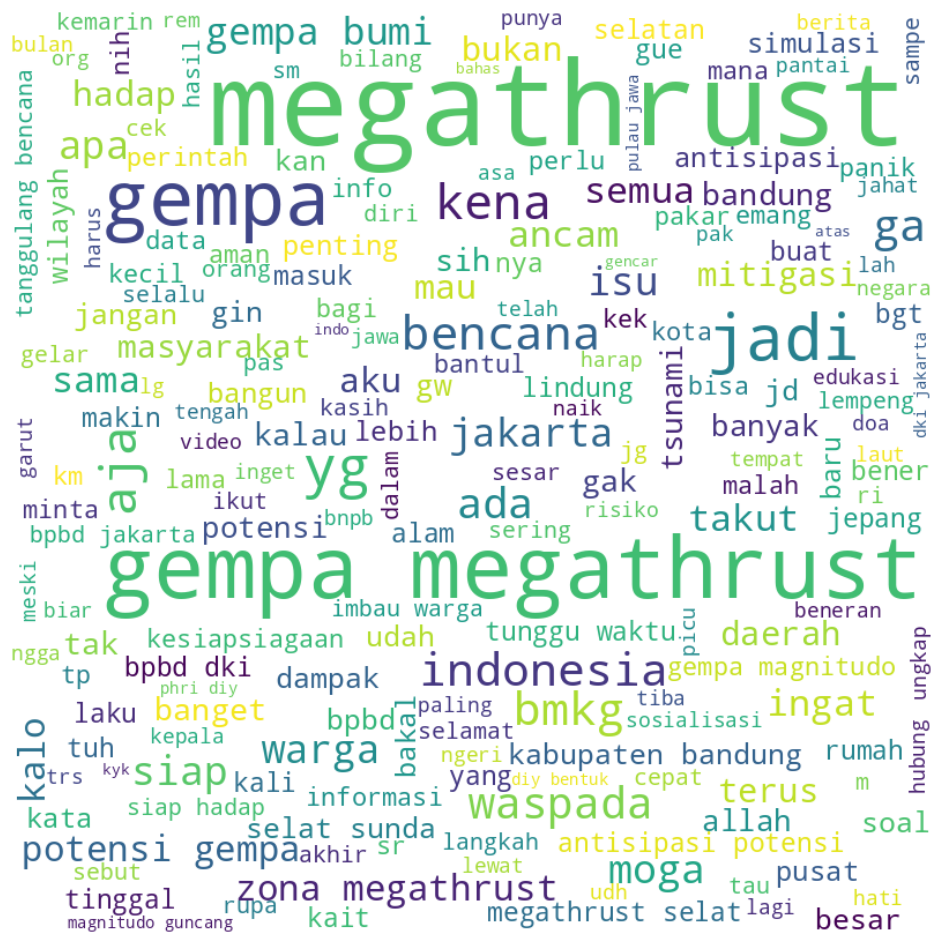

In [52]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from collections import Counter

text = ' '.join(data_tweet['data_clean'])

wordcloud = WordCloud(background_color='white', width=800, height=800).generate(text)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Dari wordcloud di atas, dapat diketahui bahwa kata yang memiliki ukuran besar adalah 'megathrust', 'gempa, dan 'gempa megathrust' artinya ketiga kata tersebut sering muncul pada data twitter sesuai dengan topik scaping yang dilakukan. Di samping itu, terdapat kata 'jakarta', 'bandung', 'indonesia' yang merupakan nama wilayah yang menjadi perhatian atau berpotensi terdampak. Dan ada kata 'BMKG' yang merupakan lembaga penanganan gempa.

Word cloud di atas mencerminkan kompleksitas isu gempa megathrust di Indonesia, meliputi aspek geografis, lembaga terkait, dampak dan risiko, hingga respons emosional masyarakat yang dituliskan melalui media twitter.

# **Clustering**

## **Hyperparameter Tuning Clustering KMeans**

In [ ]:
kmeans = KMeans(random_state=42)
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7],
    'init': ['k-means++', 'random'],
    'max_iter': [100, 200, 300],
    'n_init': [10, 20, 30],
    'algorithm': ['lloyd', 'elkan'],
    'tol': [1e-4, 1e-3, 1e-2]
}

def custom_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)
    return silhouette + calinski - davies

grid_search = GridSearchCV(
    kmeans,
    param_grid,
    scoring=custom_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_scaled)
best_params = grid_search.best_params_
print("Parameter terbaik:", best_params)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Parameter terbaik: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 2, 'n_init': 30, 'tol': 0.0001}


## **Membangun Clustering**

In [ ]:
kmeans_params = {
    'n_clusters' : 2,
    'random_state': 42,
    'algorithm': 'lloyd',
    'init': 'k-means++',
    'max_iter': 100,
    'n_init': 30,
    'tol': 0.0001
}

kmeans = KMeans(**kmeans_params)
kmeans.fit(pca_df)

pca_df['Cluster'] = kmeans.labels_
pca_df.head()

,PC1,PC2,Cluster
0,0.487673,4.102923,0
1,2.786079,2.239610,0
2,-0.488425,-0.709407,0
3,-0.475981,-0.657876,0
4,-0.592322,-2.005826,0


## **Evaluasi Clustering**

In [ ]:
silhouette = silhouette_score(pca_df, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(pca_df, kmeans.labels_)
davies_bouldin = davies_bouldin_score(pca_df, kmeans.labels_)

print("Evaluasi Cluster:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

Evaluasi Cluster:
Silhouette Score: 0.8638
Calinski-Harabasz Index: 303.7584
Davies-Bouldin Index: 0.1701


* Silhoutte score sebesar 0.8638 dapat mengindikasikan bahwa objek-objek dalam satu cluster sangat mirip satu sama lain dan berbeda secara signifikan dari objek-objek di cluster lain . Nilai tersebut dapat dikatakan baik karena mendekati 1.

* Calinski-Harabasz Index sebesar 303.7584 yang besar menandakan bahwa cluster
yang dihasilkan dapat dikatakan baik karena antar cluster yang berbeda terpisah
signifikan, artinya jarak antar cluster besar. Di samping itu, objek dalam cluster
sangat dekat satu sama lain artinya jarak dalam cluster kecil.

* Davies-Bouldin Index sebesar 0.1701 yang cukup kecil menandakan bahwa cluster
yang dihasilkan terpisah dengan baik dan objek dalam cluster homogen atau serupa. Nilai tersebut dapat dikatakan baik karena mendekati 0.


## **Visualisasi Clustering**

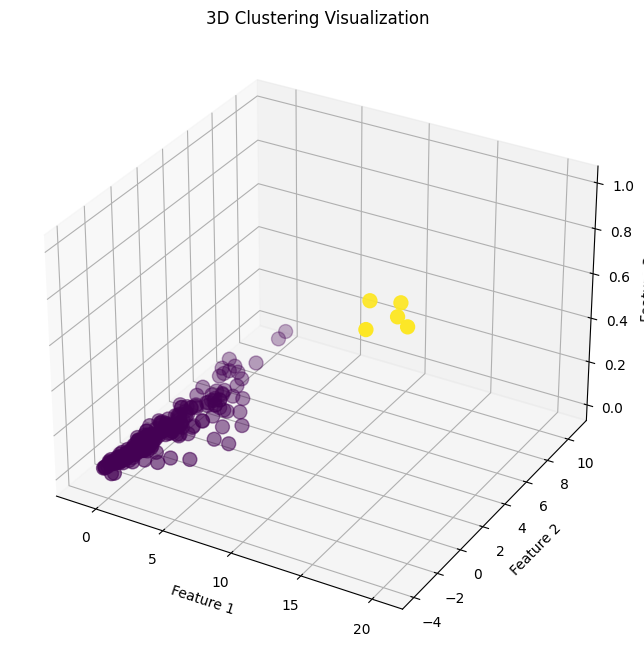

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], pca_df.iloc[:, 2], c=pca_df['Cluster'], cmap='viridis', s=100)
ax.set_title("3D Clustering Visualization")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

Dari visualisasi tersebut, setiap titik data dengan warna yang berbeda menunjukkan cluster yang  berbeda. Dapat dikatakan bahwa kedua cluster terpisah dengan baik ditunjukkan adanya jarak pada suatu cluster dengan cluster lainnya. Di samping itu, jarak data dalam satu cluster saling berdekatan. Sehingga dapat
dikatakan bahwa kualitas clustering sudah cukup baik dalam mengelompokkan fitur data teks twitter dengan topik 'gempa megthrust'.

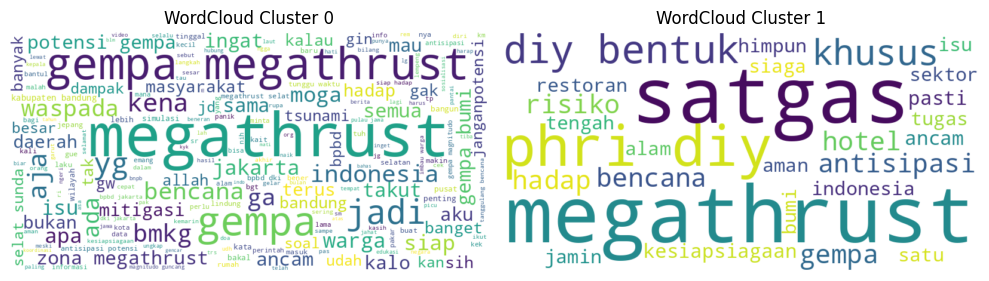

In [ ]:
# Menambahkan kolom cluster ke df
data_tweet['Cluster'] = pca_df['Cluster']

# Membuat WordCloud untuk Cluster 0
cluster_0_text = ' '.join(data_tweet[data_tweet['Cluster'] == 0]['data_clean'])
wordcloud_cluster_0 = WordCloud(width=800, height=400, background_color='white').generate(cluster_0_text)

# Membuat WordCloud untuk Cluster 1
cluster_1_text = ' '.join(data_tweet[data_tweet['Cluster'] == 1]['data_clean'])
wordcloud_cluster_1 = WordCloud(width=800, height=400, background_color='white').generate(cluster_1_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_cluster_0, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Cluster 0')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_cluster_1, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Cluster 1')

plt.tight_layout()
plt.show()

Dari wordcloud masing-masing cluster di atas, dapat diinterpretasikan bahwa data yang masuk pada cluster 0 memiliki fokus utama gempa megthrust sebagai bencana dan dampaknya. Hal tersebut dapat dilihat pada wordcloud, kata yang berukuran besar adalah 'gempa megathrust', 'megathrust', 'bencana', 'indonesia', 'zona megathrust', dan 'potensi'. Sedangkan pada cluster 1 memiliki fokus utama pada antisipasi gempa megathrust, dilihat pada wordcloud kata yang berukuran besar adalah 'satgas', 'megathrust', 'phri', 'antisipasi', 'risiko', dan 'siaga'.

# **Social Network Analysis**

In [3]:
df = pd.read_csv('/content/tweet_megathrust.csv')
df.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1839334909535723662,Thu Sep 26 16:03:10 +0000 2024,2,Pelatihan Penanggulangan Bencana Bertema Megat...,1839334909535723662,https://pbs.twimg.com/media/GYahGdhbMAE8o8V.jpg,NaN,in,"Kebumen, Indonesia",0,0,0,https://x.com/Pusdalops_Kbm/status/18393349095...,945893297695760384,Pusdalops_Kbm
1,1839318092423602301,Thu Sep 26 14:56:20 +0000 2024,1,Dalam rangka menyongsong Bulan Pengurangan Ris...,1839318092423602301,https://pbs.twimg.com/ext_tw_video_thumb/18393...,NaN,in,NaN,0,0,0,https://x.com/BintangSoesman/status/1839318092...,1453637635562299392,BintangSoesman
2,1839142276880281925,Thu Sep 26 12:29:33 +0000 2024,1,@_TheHolocaust Ahaha karna dikit2 bawa2 agama ...,1839281153003630636,NaN,_TheHolocaust,in,Indonesia,0,1,0,https://x.com/LAlverno/status/1839281153003630636,2580363818,LAlverno
3,1839258222223569152,Thu Sep 26 11:17:24 +0000 2024,0,@zhoreia IMUYNYA JIMAT PROTEKSI RUMAH DARI GEM...,1839262996943745359,NaN,zhoreia,in,NaN,0,1,0,https://x.com/httpsxixi/status/183926299694374...,739796014500962304,httpsxixi
4,1838856480579285290,Thu Sep 26 10:00:08 +0000 2024,0,@WowokGg @youadams_ @folkshittmedia Emang kalo...,1839243548564271126,NaN,WowokGg,in,NaN,0,0,0,https://x.com/Pelangi28342329/status/183924354...,1131222461591236609,Pelangi28342329


## **Reply/Interaction Network**

> Melakukukan analisis jaringan sosial dengan membangun graf yang menggambarkan interaksi antar pengguna Twitter berdasarkan mention di postingan atau tweet dengan topik 'gempa megathrust'. Interaksi tersebut direpresentasikan sebagai *directed graph* dengan node adalah akun pengguna dan edge adalah arah mention.

In [8]:
G_mention = nx.DiGraph()
for r in df.iterrows():
    author = r[1]['username']
    author = f'@{author}'
    text = r[1]['full_text']
    try:
      timestamp = pd.to_datetime(r[1]['created_at'])
    except:
      continue

    mentions = set(re.findall(r'@(\w+)', text))

    if len(mentions)>0:
      for u in mentions:
        u = f'@{u}'
        G_mention.add_edge(author, u, timestamp=timestamp)
print(f"Number of edges added to the graph: {G_mention.number_of_edges()}") # Print the number of edges in the graph

Number of edges added to the graph: 145


Di dapatkan hasil bhawa sebanyak 145 edge ditambahkan, artinya terdapat 145 edge atau hubungan mention pengguna twitter yang membahas 'gempa megathrust'.

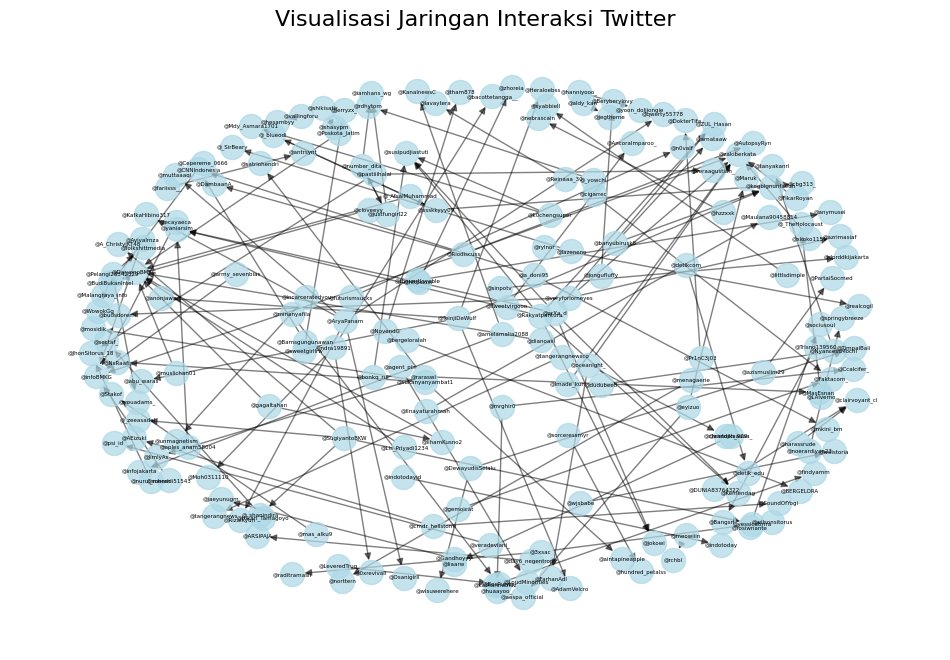

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Menggambarkan graf
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_mention, k=0.5)

# Menggambar node dan edge
nx.draw_networkx_nodes(G_mention, pos, node_size=300, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G_mention, pos, arrowstyle='-|>', arrowsize=10, width=1, alpha=0.5)

# Menambahkan label untuk setiap node
labels = {node: node for node in G_mention.nodes()}
nx.draw_networkx_labels(G_mention, pos, labels, font_size=4)

# Menampilkan judul dan menghilangkan sumbu
plt.title('Visualisasi Jaringan Interaksi Twitter', fontsize=16)
plt.axis('off')
plt.show()

# **Centrality Measures**

**Menghitung beberapa *centrality measures* atau ukuran pemusatan dari graf G_mention menggunakan librray NetworkX, antara lain:**

* Degree centrality: Mengukur jumlah koneksi langsung (edges) yang dimiliki oleh sebuah node.

* Closeness centrality: Mengukur seberapa dekat sebuah node dengan semua node lain dalam jaringan.

* Betweenness centrality: Mengukur seberapa sering sebuah node muncul di jalur terpendek antara dua node lain.

In [19]:
graph_centrality = nx.degree_centrality(G_mention)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(G_mention)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(G_mention, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

In [20]:
print(f'Degree Centrality: {graph_centrality}')
print(f'Closeness Centrality:  {graph_closeness}')
print(f'Betweenness Centrality:  {graph_betweenness}')

Degree Centrality: {'@LAlverno': 0.004878048780487805, '@_TheHolocaust': 0.004878048780487805, '@httpsxixi': 0.004878048780487805, '@zhoreia': 0.004878048780487805, '@Pelangi28342329': 0.014634146341463414, '@youadams_': 0.004878048780487805, '@folkshittmedia': 0.004878048780487805, '@WowokGg': 0.004878048780487805, '@sinpotv': 0.004878048780487805, '@dprddkijakarta': 0.004878048780487805, '@menagaerie': 0.004878048780487805, '@norttern': 0.004878048780487805, '@futurismsucks': 0.004878048780487805, '@n0valf': 0.004878048780487805, '@Gandhoyyy': 0.004878048780487805, '@jaeyunugm': 0.004878048780487805, '@TeinjiDeWulf': 0.024390243902439025, '@anonjawa': 0.004878048780487805, '@Heraloebss': 0.004878048780487805, '@kegblgnunfaedh': 0.00975609756097561, '@fariisss__': 0.004878048780487805, '@antrsynt': 0.004878048780487805, '@Pr1nC3j03': 0.004878048780487805, '@DokterTifa': 0.004878048780487805, '@aandikaaaaa_': 0.004878048780487805, '@liaarw': 0.004878048780487805, '@katharinabluz': 0.00

## **Top 10 Degree Centrality**

Top 10 users based on Degree Centrality (G_mention):
@DaryonoBMKG: 0.0341
@zakiberkata: 0.0293
@TeinjiDeWulf: 0.0244
@infoBMKG: 0.0244
@AryaPanam: 0.0244
@Rakyatpantura: 0.0244
@arXa_d: 0.0244
@SugiyantoBKW: 0.0195
@susipudjiastuti: 0.0195
@Riodiscuss: 0.0195


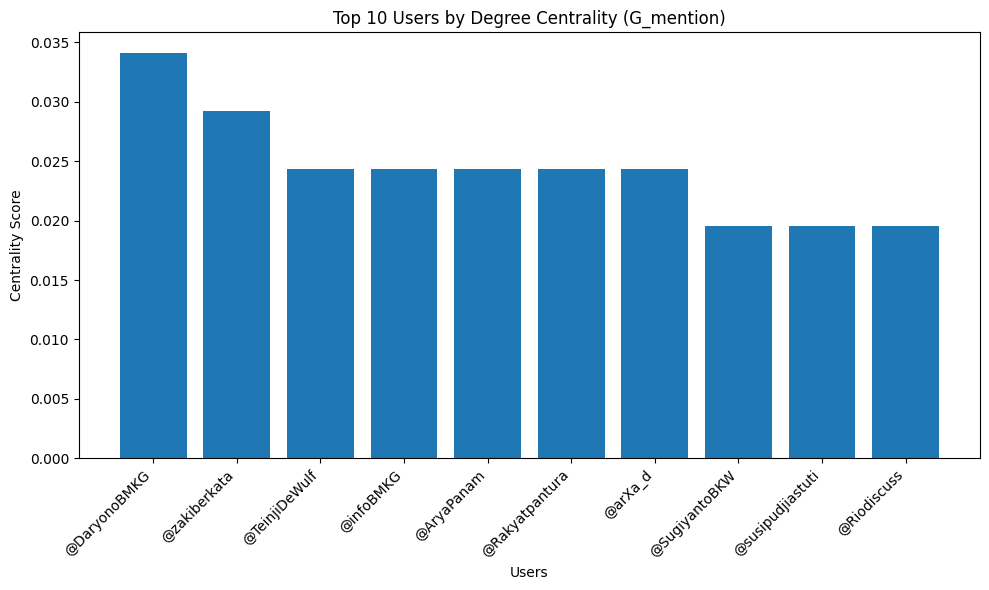

In [21]:
graph_centrality = nx.degree_centrality(G_mention)
top_degree_mention = sorted(graph_centrality.items(), key=itemgetter(1), reverse=True)[:10]
print("Top 10 users based on Degree Centrality (G_mention):")
for user, score in top_degree_mention:
    print(f"{user}: {score:.4f}")

def plot_centrality(centrality_dict, title):
    plt.figure(figsize=(10, 6))
    users, scores = zip(*sorted(centrality_dict.items(), key=itemgetter(1), reverse=True)[:10])
    plt.bar(users, scores)
    plt.title(title)
    plt.xlabel('Users')
    plt.ylabel('Centrality Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_centrality(graph_centrality, 'Top 10 Users by Degree Centrality (G_mention)')


Dari output di atas, pengguna dengan degree centrality semakin tingi menunjukkan bahwa  semakin sering pula pengguna tersebut terlibat dalam interaksi. Dari output di atas, pengguna dengan degree centrality tertinggi adalah @DaryonoBMKG, diikuti oleh @zakiberkata, @TeinjiDeWulf, dan @infoBMKG. @DaryonoBMKG memiliki degree centrality tertinggi menunjukkan bahwa pengguna ini sering di-reply atau disebutkan paling banyak oleh pengguna lain. Ini menunjukkan bahwa @DaryonoBMKG kemungkinan adalah sumber informasi yang penting atau memiliki pengaruh yang besar dalam diskusi yang terjadi.

Pengguna tersebut dapat dianggap sebagai 'pemain kunci' dalam percakapan topik 'gempa megathrust' karena banyak pengguna lain yang berinteraksi dengan mereka.

## **Top 10 Closeness Centrality**


Top 10 users based on Closeness Centrality (G_mention):
@DaryonoBMKG: 0.0341
@zakiberkata: 0.0293
@infoBMKG: 0.0244
@susipudjiastuti: 0.0195
@yaniarsim: 0.0146
@kegblgnunfaedh: 0.0098
@TimpalBali: 0.0098
@JhonSitorus_18: 0.0098
@BosPurwa: 0.0098
@Kemendag: 0.0098


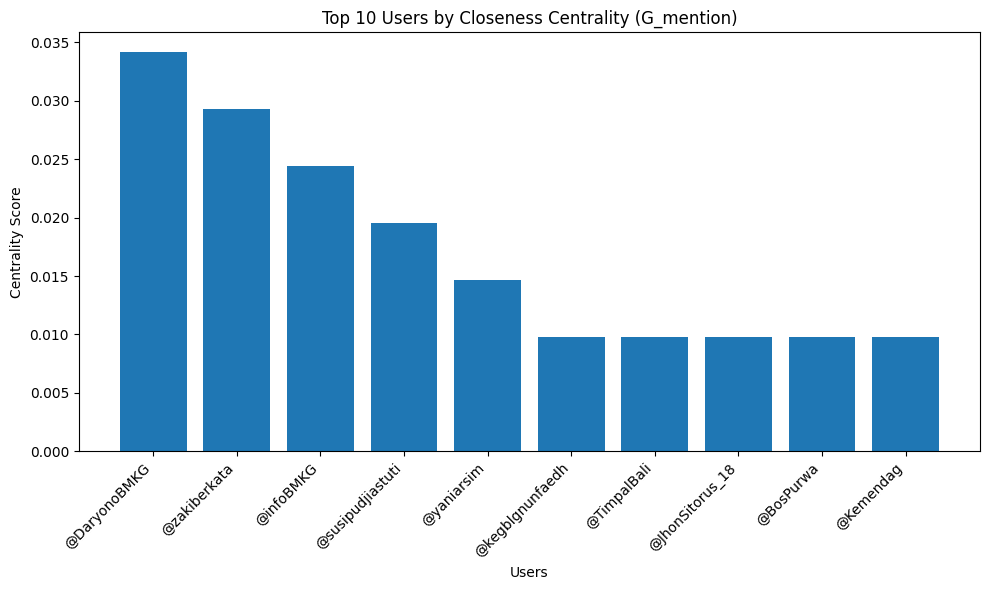

In [22]:
graph_closeness = nx.closeness_centrality(G_mention)
top_closeness_mention = sorted(graph_closeness.items(), key=itemgetter(1), reverse=True)[:10]
print("\nTop 10 users based on Closeness Centrality (G_mention):")
for user, score in top_closeness_mention:
    print(f"{user}: {score:.4f}")

plot_centrality(graph_closeness, 'Top 10 Users by Closeness Centrality (G_mention)')


Dari output di atas, pengguna dengan closeness  centrality semakin tingi menunjukkan bahwa  semakin cepat pula kemungkinan pengguna tersebut dapat menjangkau pengguna lain. Dari output di atas, pengguna dengan closeness  centrality tertinggi adalah @DaryonoBMKG, diikuti oleh @zakiberkata, @infoBMKG, dan @susipudjiastuti.

Pengguna tersebut dapat dianggap sebagai 'pemberi pengaruh' dalam percakapan topik 'gempa megathrust' karena dapat menyebarkan informasi atau mempengaruhi percakapan lebih efisien. Mereka berada di posisi strategis dalam mempengaruhi jaringan.

## **Top 10 Betweenness Centrality**


Top 10 users based on Betweenness Centrality (G_mention):
@ssskkyyy09: 0.0000
@LAlverno: 0.0000
@_TheHolocaust: 0.0000
@httpsxixi: 0.0000
@zhoreia: 0.0000
@Pelangi28342329: 0.0000
@youadams_: 0.0000
@folkshittmedia: 0.0000
@WowokGg: 0.0000
@sinpotv: 0.0000


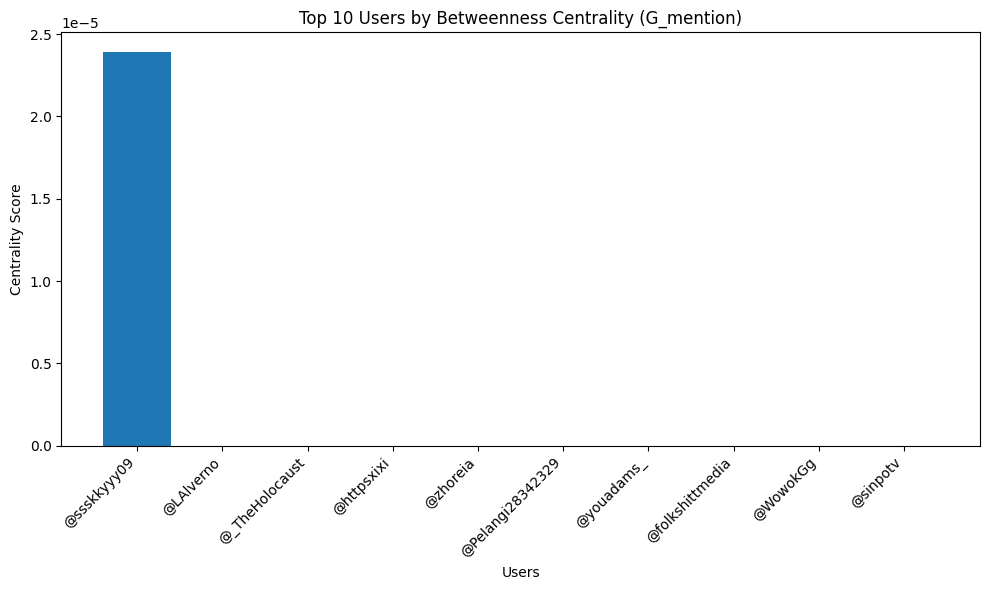

In [23]:
graph_betweenness = nx.betweenness_centrality(G_mention, normalized=True, endpoints=False)
top_betweenness_mention = sorted(graph_betweenness.items(), key=itemgetter(1), reverse=True)[:10]
print("\nTop 10 users based on Betweenness Centrality (G_mention):")
for user, score in top_betweenness_mention:
    print(f"{user}: {score:.4f}")

plot_centrality(graph_betweenness, 'Top 10 Users by Betweenness Centrality (G_mention)')

Dari output di atas, pengguna dengan betweenness centrality semakin tingi menunjukkan bahwa  semakin sering pula pengguna tersebut dalam menjebatani koneksi dalam jaringan. Dari output di atas, pengguna dengan betweenness tertinggi adalah @ssskkyyy09

Pengguna tersebut dapat dianggap sebagai 'penghubung' atau 'broker' antara kelompok pengguna lain dalam percakapan topik 'gempa megathrust'. Mereka dapat memberi peran penting dalam memfasilitasi komunikai antar kelompok jaringan sehingga mereka memiliki kekuatan untuk mempengaruhi percakapan yang terjadi di antara kelompok yang berbeda.

# **Visualisasi Network**

<ipython-input-33-48c00c2a8a6c>:43: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label="Degree Centrality")


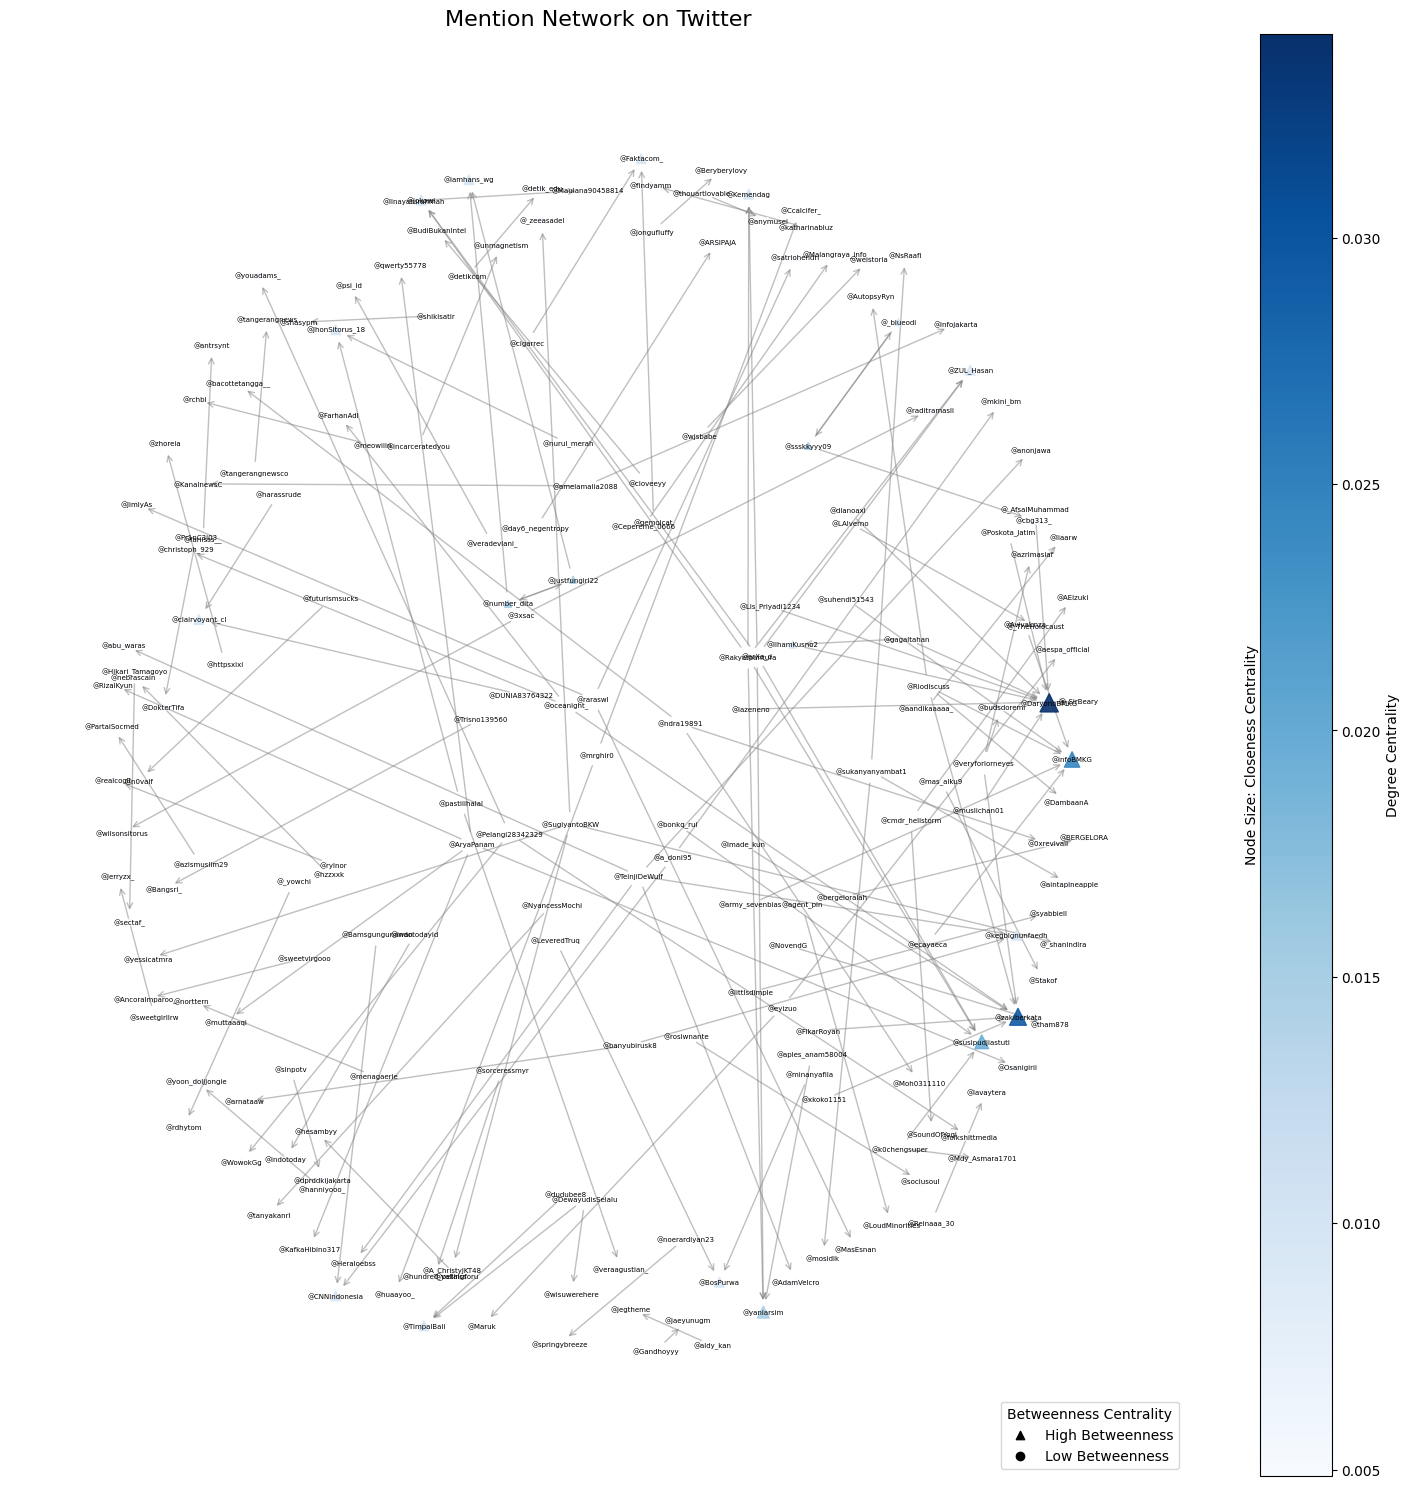

In [33]:
plt.figure(figsize=(15, 15))

node_sizes = [5000 * graph_closeness[node] for node in G_mention]
node_colors = [graph_centrality[node] for node in G_mention]
node_shapes = []
betweenness_threshold = np.percentile(list(graph_betweenness.values()), 90)  # 10% teratas
for node in G_mention:
    if graph_betweenness[node] >= betweenness_threshold:
        node_shapes.append('^')
    else:
        node_shapes.append('o')

pos = nx.spring_layout(G_mention, k=0.3, seed=42)

for shape in set(node_shapes):
    node_list = [node for node in G_mention if node_shapes[list(G_mention.nodes()).index(node)] == shape]
    nx.draw_networkx_nodes(G_mention, pos,
                           nodelist=node_list,
                           node_size=[node_sizes[list(G_mention.nodes()).index(node)] for node in node_list],
                           node_color=[node_colors[list(G_mention.nodes()).index(node)] for node in node_list],
                           node_shape=shape,
                           cmap=plt.cm.Blues,

nx.draw_networkx_edges(G_mention, pos, arrowstyle='->', arrowsize=10, edge_color='gray', alpha=0.5)

nx.draw_networkx_labels(G_mention, pos, font_size=5, font_color='black')

plt.title("Mention Network on Twitter", fontsize=16)

sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, label="Degree Centrality")

plt.scatter([], [], c='k', marker='^', label='High Betweenness')
plt.scatter([], [], c='k', marker='o', label='Low Betweenness')
plt.legend(title="Betweenness Centrality", loc="lower right")

plt.text(1.05, 0.5, 'Node Size: Closeness Centrality', rotation=90, va='center', transform=plt.gca().transAxes)

plt.axis('off')
plt.tight_layout()
plt.show()


Graf di atas merupakan visualisasi *social network analysis* data twitter dengan topik 'gempa megathrust'. Setiap node merepresenatsikan akun twitter yang terlibat dalam mention, sementara edge merepresentasikan terdapat hubungan mention antara 2 pengguna beserta arah mentionnya. Semakin besar ukuran node maka semakin tinggi *closeness centrality*, yang mengukur seberapa dekat suatu node ke node lain dalam jaringan. Begitu pula pada pewarnaa node, semakin gelap warna node maka semakin tinggi *degree centrality*, yang mengukur jumlah koneksi langsung (mention) yang dimiliki setiap node. Bentuk node segitiga menunjukkan *betweenness centrality* yang tinggi, berarti akun tersebut berfungsi sebagai penghubung (broker) antara grup atau akun yang berbeda, memainkan peran penting dalam menyebarkan informasi dalam jaringan. Sementara node lingkaran menunjukkan *betweenness centrality* yang rendah.

Visualisasi graf jaringan mention twitter dengan topik 'gempa megathrust' di atas, terdapat beberapa node berbentuk segitiga yang memiliki ukuran lebih besar serta warna lebih gelap secara signifikan dibandingkan dengan node lain, antara lain @daryonoBMKG, @Zakiberkata,@infoBMKG, dan @susipudjiastuti.

# **Kesimpulan**

Dari *social network analysis* atau analisis jaringan sosial dengan data berusmber dari media sosial twitter yang mengangkat topik 'gempa megathrust', terdapat beberapa akun yang mengungah tweet mengandung topik tersebut. Beberapa diantaranya adalah akun @DaryonoBMKG @zakiberkata, @infoBMKG, dan @susipudjiastuti.

Akun @DaryonoBMKG dan @infoBMKG merupakan `pemantik atau tokoh utama` pada diskusi topik 'gempa megathrust' dibuktikan dengan tingginya nilai Degree Centrality serta Closeness Centrality, menunjukkan peran mereka sebagai sumber informasi utama serta dalam penyebaran atau mendiskusikan informasi mengenai topik tersebut.

Akun @ssskkyyy09 merupakan `broker informasi` dibuktikan dengan tingginya nilai  Betweenness Centrality jauh di atas pengguna lainnya. Ini menunjukkan perannya sebagai jembatan yang menyebarkan informasi dari sumber utama ke kelompok pengguna yang lebih luas.

`Pola interaksi` tampaknya berpusat pada beberapa akun utama, yaitu pada @daryonoBMKG dan @infoBMKG, yang kemungkinan besar menyediakan informasi resmi atau update terkini.

Dari visualisasi SNA, tidak terlihat adanya kubu yang berlawanan secara jelas. Diskusi tampaknya lebih berfokus pada penyebaran dan pertukaran informasi dibandingkan dengan perdebatan antar kubu.